In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
from sys import modules
import seaborn as sns
from eval_utils import my_stupid_evaluation_function,mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Import Data 
X_data= pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/X.csv")
y_data = pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/y.csv")

#Set index
X_data = X_data.set_index('id')
y_data = y_data.set_index('id')

#join
df = X_data.join(y_data, on = 'id') 

יצירת עותק

In [3]:
#Copy
#Run this for raw data
df = df.copy()

#Check data shap
print(df.shape)

#Columns and type
print(df.info())

(5363, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5363 entries, 2477 to 3572
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0.1         5363 non-null   int64  
 1   Unnamed: 0           5363 non-null   int64  
 2   Age                  5359 non-null   float64
 3   Gender               5359 non-null   object 
 4   Education Level      5360 non-null   object 
 5   Job Title            5361 non-null   object 
 6   Years of Experience  5360 non-null   float64
 7   Country              5363 non-null   object 
 8   Race                 5363 non-null   object 
 9   height               5363 non-null   float64
 10  weight               5361 non-null   float64
 11  professionalism      5360 non-null   float64
 12  Salary               5358 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 586.6+ KB
None


In [4]:
#Drop
#Shape after Drop Null
df = df.dropna()
print(df.shape)

#Drop Retendent Columns
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
print(df.shape)

(5355, 13)
(5355, 11)


חלוקה ושמירה על עקביות

In [5]:
df_train, df_test = train_test_split(df, random_state=1, test_size=0.2)
print(df_train.shape)
print(df_test.shape)

(4284, 11)
(1071, 11)


In [54]:
#Numery
df_n = df[['Age','Years of Experience','height','weight','professionalism','Salary']]

#Category
df_c = df[['Gender',"Education Level", "Job Title",'Country','Race','Salary']]

df_train, df_test = train_test_split(df_n, random_state=1, test_size=0.2)
print(df_train.shape)
print(df_test.shape)

df.head()

(4284, 6)
(1071, 6)


,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary
id,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0
64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0
924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0


In [28]:
X_train, y_train = df_train.drop("Salary", axis=1), df_train["Salary"]
X_test, y_test = df_test.drop("Salary", axis=1), df_test["Salary"]

מחשב משכורת ממוצעת למקצועיות

In [71]:
class MyModel:
    def __init__ (self, col):
        self.col = col

    def fit(self, X, y):
        
        #x and y are the ones from the training set
        self.col_salary_mapper_ = y.groupby(X[self.col]).mean().rename("Salary_hat") 
        self.fallback_salary_ = y.mean()

    def predict(self, X):
        """"We"""
        out = X.join(self.col_salary_mapper_, on = self.col)
        out = out["Salary_hat"]
        out = out.fillna(self.fallback_salary_) #what we didnt predict well will be in fallback price
        return out 
      
    
    


In [86]:
score_board = {}
score_board_mse = {}
for col in X_train.columns:
    reg = MyModel(col = col)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
    score_board[col] = my_score
  
    my_mse = mean_absolute_error(y_test, y_pred)
    score_board_mse[col] = my_mse


In [95]:
#Base evaluation funtion
pd.Series(score_board)

'professionalism'

In [90]:
#Base evaluation funtion
pd.Series(score_board_mse)

Age                    27171.778648
Years of Experience    21709.747805
height                 45948.825620
weight                 45948.825620
professionalism        16139.642611
dtype: float64

In [92]:
#we found that professionalism yield the best score
reg = MyModel(col = "professionalism")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [93]:
y_test.to_frame().join(y_pred)

,Salary,Salary_hat
id,,
1639,150000.0,125882.352941
1915,190000.0,165000.000000
1568,140000.0,121815.161290
1475,70000.0,58270.833333
2766,160000.0,144583.333333
...,...,...
6025,30000.0,51587.864078
5024,110000.0,114054.642857
421,190000.0,122916.522727


In [99]:
best_col = pd.Series(score_board).idxmax()

#we found that professionalism yield the best score
reg = MyModel(col = best_col)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

"""2/3 ways for join """
y_test.to_frame().join(y_pred)
evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

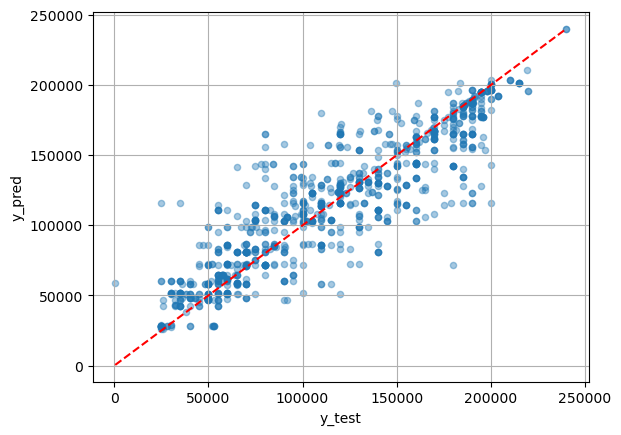

In [100]:
# Sample data (replace these with your actual data)
evaluation_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Create a scatter plot using DataFrame column names
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree line

In [10]:
reg.professionalism_salary_mapper_

professionalism
0.0        28446.814286
22.0       25000.000000
23.0       46481.357143
24.0       60350.443038
25.0       51587.864078
              ...      
1710.0    121450.000000
1728.0    192480.142857
1736.0    197354.000000
1881.0    188232.000000
2040.0    188651.000000
Name: Salary_hat, Length: 265, dtype: float64

In [11]:
y_pred

id
1639    125882.352941
1915    165000.000000
1568    121815.161290
1475     58270.833333
2766    144583.333333
            ...      
6025     51587.864078
5024    114054.642857
421     122916.522727
4934    111033.844156
5067    142236.267857
Name: Salary_hat, Length: 1071, dtype: float64

In [12]:
y_test

id
1639    150000.0
1915    190000.0
1568    140000.0
1475     70000.0
2766    160000.0
          ...   
6025     30000.0
5024    110000.0
421     190000.0
4934     80000.0
5067     95000.0
Name: Salary, Length: 1071, dtype: float64

נוודא שהמספרים מסתדרים והמבנים מסתדרים

In [13]:
y_pred          #1071
X_test.shape    #1071
(y_test.index == y_pred.index).mean() #mean = 1
y_pred.index.duplicated().mean() #duplicated = 0


0.0

In [14]:
from eval_utils import my_stupid_evaluation_function,mean_absolute_error

In [56]:
#my_score = my_stupid_evaluation_function(y_test.head(),y_pred.head()) #senety check  expect 0
my_score = my_stupid_evaluation_function(y_test, y_pred)
print(my_score)

mean_absolute_error(y_test, y_pred)


0.3025210084033613


27171.77864810174

In [57]:
#Error
#def my_stupid_evaluation(y_test, y_pred):
#    strikes = 0
#    for i in range(len(y_test)):
#       differnce = abs(y_test[i]-y_pred[i])/y_test[i]
#       if differnce > 0.1:
#            strikes +=1
#    return strikes/len(y_test) 

#my_stupid_evaluation(y_test, y_pred)

#Nan problem
#mean_squared_error(y_test, y_pred)

y_pred.isna().sum()

0

In [ ]:
#Example All works
y_predd = np.array([1,2,4])
y_testt = np.array([1,2,3])
#my_stupid_evaluation(y_testt, y_predd)
#my_stupid_evaluation_function(y_testt, y_predd)
mean_squared_error(y_testt, y_predd)


0.3333333333333333

In [58]:
#בודק אם יש את כל הערכים בין טסט לטריין כאשר העמודה היא רציפה
#set(X_train["professionalism"]) - set(X_test["professionalism"])
set(X_test["professionalism"]) - set(X_train["professionalism"])

{11.5, 33.0, 352.0, 832.0, 882.0, 935.0, 1040.0, 1173.0, 1175.0}

In [59]:
X_test[X_test["professionalism"]==33]

,Age,Years of Experience,height,weight,professionalism
id,,,,,
4393,35.0,2.0,2.264594,60.369088,33.0


In [52]:
#הייתי מצפה ל nan אבל אני כן מקבל ערך
some_sample = X_test[X_test["professionalism"]==33.0]
reg.predict(some_sample)

id
4393    130030.923767
Name: Salary_hat, dtype: float64

In [62]:
y_pred.isna().sum()

0

In [65]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred) #1226993433.0564091
rmse = mean_squared_error(y_test, y_pred, squared=False) #35028.46603915748
rmse

35028.46603915748